# Predict future sales

## EDA

### Import libraries

In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 1000)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as skl
import lightgbm as lgb
import xgboost as xgb
import catboost as cgb

import pickle as pcl
import gc

from itertools import product
from tqdm import tqdm, tqdm_notebook

curr_libs = [np, pd, mpl, sns, skl, lgb, xgb, cgb]

Let's have a look to the versions of used libraries:

In [2]:
for lib in curr_libs:
    print(f'{lib.__name__} - {lib.__version__}')

numpy - 1.18.5
pandas - 1.1.4
matplotlib - 3.1.1
seaborn - 0.11.0
sklearn - 0.19.0
lightgbm - 3.1.0
xgboost - 1.2.1
catboost - 0.24.3


### Import source data

In [3]:
sales_train = pd.read_csv('../data/sales_train.csv.gz')
sales_test = pd.read_csv('../data/test.csv.gz')
items = pd.read_csv('../data/items.csv')
item_categories = pd.read_csv('../data/item_categories.csv')
shops = pd.read_csv('../data/shops.csv')

Have a quick look to the data:

In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
sales_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


### Quick data analysis

We are going to process a lot of data and thereby we have to optimize the taken memory. Thereby first we are going to optimize the consumed memory amount. Let's have a quick look to the types of our data.

In [9]:
sales_train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [10]:
sales_test.dtypes

ID         int64
shop_id    int64
item_id    int64
dtype: object

In [11]:
items.dtypes

item_name           object
item_id              int64
item_category_id     int64
dtype: object

In [12]:
item_categories.dtypes

item_category_name    object
item_category_id       int64
dtype: object

In [13]:
shops.dtypes

shop_name    object
shop_id       int64
dtype: object

According to the data types we've seen we can suppose the following conversions:
* `int64 -> int32`
* `float64 -> float32`
* if column name is `'date'` than `object->date`

For these conversions we well use a bit modified version of type downcasting function provided by the authors of this course

In [14]:
def downcast_dtypes(df, inplace=False):
    if(inplace == False):
        df = df.copy()
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype == "int64"]
    date_cols =  [c for c in df if (c == 'date' and df[c].dtype == "object")]
        
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    for date_col in date_cols:
        df[date_col] = pd.to_datetime(df[date_col])
    
    if(inplace == False):
        return df

And let's apply these conversions immediately

In [15]:
downcast_dtypes(sales_train, inplace=True)
downcast_dtypes(sales_test, inplace=True)
downcast_dtypes(items, inplace=True)
downcast_dtypes(item_categories, inplace=True)
downcast_dtypes(shops, inplace=True)

First let's have a look to the shops: does test dataset contain all the shops presented in the train dataset:

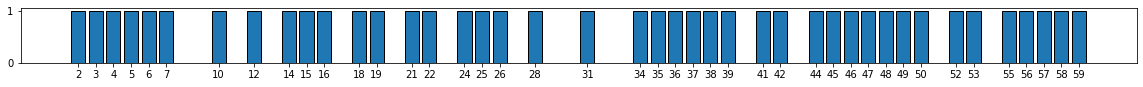

In [17]:
test_shops = np.sort(sales_test['shop_id'].unique())
fig = plt.figure(figsize=(20, 1))
plt.bar(test_shops, np.ones(len(test_shops)), edgecolor='black')
plt.xticks(test_shops)
plt.show()

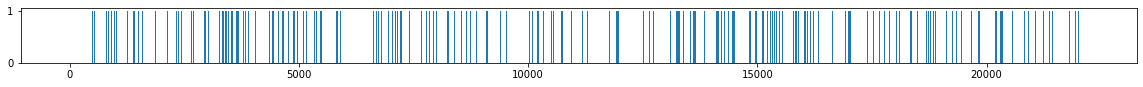

In [18]:
test_items = np.sort(sales_test['item_id'].unique())
fig = plt.figure(figsize=(20, 1))
plt.bar(test_items, np.ones(len(test_items)))
plt.show()

We've got the similar case for items. The difference is that test set contains almost all shops and relatively small number of items. How small this number is?

In [19]:
train_item_len = len(sales_train['item_id'].unique())
train_shop_len = len(sales_train['shop_id'].unique())
test_item_len = len(sales_test['item_id'].unique())
test_shop_len = len(sales_test['shop_id'].unique())
print(f'Train set contains info on {train_item_len} item(s) for {train_shop_len} shop(s)')
print(f'Test set contains info on {test_item_len} item(s) for {test_shop_len} shop(s)')

Train set contains info on 21807 item(s) for 60 shop(s)
Test set contains info on 5100 item(s) for 42 shop(s)


This fact can help us in future to avoid prediction of all data items for all shops, but just predict data for the shops and items presented in the test set. It potentially can save a lot of time by training models only on items are really used in test set. 

But in order to use these ideas we have to be sure in two facts: 
* sales of different items do not depend on each other
* sales of different shops do not depend on each other

It supposes some investigation and therefore we postpone it.